In [397]:
import pandas as pd
from prophet import Prophet
from pymongo import MongoClient
from prophet.plot import plot_plotly, plot_components_plotly
import os
import time

db = MongoClient(os.environ["DB_HOST"], int(os.environ["DB_PORT"]))
collection = 'covid_county_formatted'
cursor = db.sustaindb[collection].find()
df = pd.DataFrame(list(cursor))
df

,_id,date,county,state,fips,cumulative_cases,cumulative_deaths,cases,deaths,GISJOIN,formatted_date
0,605420df8dd202bf891eb049,2020-03-25,Autauga,Alabama,01001,4,0.0,3,0,G0100010,2020-03-25
1,605420df8dd202bf891eb04a,2020-03-28,Autauga,Alabama,01001,6,0.0,0,0,G0100010,2020-03-28
2,605420df8dd202bf891eb04b,2020-03-29,Autauga,Alabama,01001,6,0.0,0,0,G0100010,2020-03-29
3,605420df8dd202bf891eb04c,2020-03-30,Autauga,Alabama,01001,7,0.0,1,0,G0100010,2020-03-30
4,605420df8dd202bf891eb04d,2020-03-31,Autauga,Alabama,01001,7,0.0,0,0,G0100010,2020-03-31
...,...,...,...,...,...,...,...,...,...,...,...
1064945,605420f18dd202bf892ee89b,2020-08-30,Washakie,Wyoming,56043,107,5.0,0,0,G5600430,2020-08-30
1064946,605420f18dd202bf892ee89c,2020-09-04,Washakie,Wyoming,56043,109,6.0,1,0,G5600430,2020-09-04
1064947,605420f18dd202bf892ee89d,2020-08-31,Washakie,Wyoming,56043,107,5.0,0,0,G5600430,2020-08-31
1064948,605420f18dd202bf892ee89e,2020-08-29,Washakie,Wyoming,56043,107,5.0,0,0,G5600430,2020-08-29


In [12]:
import time

df_cases = df[["date", "GISJOIN", "cases"]].rename(columns = {
    'date': 'ds',
    'cases': 'y'
})

all_gis_joins = df_cases['GISJOIN'].unique()
print(f'#GISJOINs: {len(all_gis_joins)}')

all_dfs = []

count = 0
time1 = time.monotonic()
for gis_join in all_gis_joins:
    count += 1
    if count % 20 == 0:
        print(count, end=', ')
    all_dfs.append(df_cases.loc[df_cases['GISJOIN'] == gis_join])
    
print(f'Time to separate pandas dataframes by GISJOIN value: {time.monotonic() - time1}')
print(f'#Dataframes: {len(all_dfs)}')

#GISJOINs: 3116
20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520, 1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740, 1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620, 2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840, 2860, 2880, 2900, 2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, Time to separate pandas dataframes by GISJOIN value: 229.87625111918896
#Dataframes: 3116


In [15]:
import pickle

f = open('pickles/all_dfs.pkl', 'wb')
time1 = time.monotonic()
pickle.dump(all_dfs, f)

print(f'Time to dump all_dfs to file: {time.monotonic() - time1}')

Time to dump all_dfs to file: 1.115097158588469


In [2]:
import pickle

all_dfs = pickle.load(open('pickles/all_dfs.pkl', 'rb'))
all_dfs

[             ds   GISJOIN   y
 0    2020-03-27  G0100010   0
 1    2020-03-25  G0100010   3
 2    2020-03-28  G0100010   0
 3    2020-03-29  G0100010   0
 4    2020-03-30  G0100010   1
 ..          ...       ...  ..
 344  2021-03-06  G0100010  11
 345  2021-03-04  G0100010  11
 346  2021-03-07  G0100010   3
 377  2021-01-16  G0100010  51
 443  2021-01-26  G0100010  33
 
 [349 rows x 3 columns],
               ds   GISJOIN   y
 347   2020-03-15  G0100030   0
 348   2020-03-14  G0100030   1
 349   2020-03-16  G0100030   0
 350   2020-03-18  G0100030   0
 351   2020-03-17  G0100030   0
 ...          ...       ...  ..
 1203  2021-03-05  G0100030  17
 1204  2021-03-07  G0100030  20
 1205  2021-03-06  G0100030  25
 1206  2021-03-03  G0100030  66
 1208  2021-03-04  G0100030  17
 
 [359 rows x 3 columns],
               ds   GISJOIN   y
 500   2021-01-22  G0100050  15
 501   2021-01-23  G0100050  12
 502   2021-01-24  G0100050  22
 503   2021-01-20  G0100050  22
 504   2021-01-13  G0100050   

In [62]:
all_dfs[50]

,ds,GISJOIN,y
17412,2020-03-13,G0101010,1
17413,2020-03-16,G0101010,1
17414,2020-03-17,G0101010,0
17415,2020-03-18,G0101010,0
17416,2020-03-19,G0101010,1
...,...,...,...
18268,2021-02-25,G0101010,45
18269,2021-03-07,G0101010,16
18270,2021-03-04,G0101010,31
18271,2021-03-06,G0101010,24


In [236]:
# model = Prophet(
#     interval_width=0.95,
#     growth='linear',
#     daily_seasonality=False,
#     weekly_seasonality=True,
#     yearly_seasonality=True,
#     seasonality_mode='multiplicative'
# )

# model.fit(df0)

def predict(df_train):
    m = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
    )
    # model.fit(df, algorithm='LBFGS')
    fit_m = m.fit(df_train, algorithm='LBFGS')
    df_train_future = m.make_future_dataframe(periods=365)
    df_train_forecast = m.predict(df_train_future)

    return fit_m, df_train_future, df_train_forecast
#     return df_train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

### Experiments with a Single County (one GIS_JOIN)

In [234]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

df0 = all_dfs[0]
model, future, forecast = predict(df0)

In [14]:
df0_cv = cross_validation(model, initial='100 days', period='7 days', horizon='7 days')
df0_p = performance_metrics(df0_cv)
df0_p.head()

INFO:prophet:Making 35 forecasts with cutoffs between 2020-07-05 00:00:00 and 2021-02-28 00:00:00


  0%|          | 0/35 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,270.032410,16.432663,11.933764,0.452501,0.681334,0.571429
1,2 days,1147.037856,33.867947,14.982417,0.334866,0.486292,0.714286
2,3 days,539.491218,23.226950,15.611905,0.515985,0.667127,0.628571
3,4 days,292.921616,17.114953,12.463372,0.374880,0.537949,0.657143
4,5 days,525.124695,22.915599,16.909532,0.599405,0.664727,0.514286


In [15]:
print(f'seasonality_prior_scale: {model.seasonality_prior_scale}')
print(f'changepoint_prior_scale: {model.changepoint_prior_scale}')
print(f'uncertainty_samples: {model.uncertainty_samples}')
print(f'seasonlity_mode: {model.seasonality_mode}')
print(f'interval_width: {model.interval_width}')
print(f'growth: {model.growth}')

seasonality_prior_scale: 10.0
changepoint_prior_scale: 0.01
uncertainty_samples: 1000
seasonlity_mode: additive
interval_width: 0.8
growth: linear


### Hyperparameter Tuning (GridSearch)

In [255]:
import itertools
from dask.distributed import Client

client = Client()

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

time1 = time.monotonic()
# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df0)  # Fit model with given params
    df_cv = cross_validation(m, initial= '300 days', period='365 days', horizon='365', parallel="dask")
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

print(f'Time: {time.monotonic() - time1}')
print(tuning_results)

/mnt/6FC71512346BCBD9/github/sustain-timeseries/venv39/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34173 instead
  warnings.warn(
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=4 threads=4, memory=15.52 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.99

Time: 74.43896052194759
    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                     0.01  33.636287
1                     0.001                     0.10  33.117152
2                     0.001                     1.00  32.540395
3                     0.001                    10.00  33.354216
4                     0.010                     0.01  33.048041
5                     0.010                     0.10  32.921845
6                     0.010                     1.00  33.238459
7                     0.010                    10.00  33.378634
8                     0.100                     0.01  13.835427
9                     0.100                     0.10  12.417437
10                    0.100                     1.00  13.836367
11                    0.100                    10.00  11.996248
12                    0.500                     0.01   7.090855
13                    0.500                     0.10   6.944353
14              

In [279]:
# min_rmse = min(tuning_results['rmse'])


    changepoint_prior_scale  seasonality_prior_scale      rmse
13                      0.5                      0.1  6.944353


6.94435288984211

In [280]:
def grid_search(df):
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here

    time1 = time.monotonic()
    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(df0)  # Fit model with given params
        df_cv = cross_validation(m, initial= '300 days', period='365 days', horizon='365', parallel="dask")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses

    print(f'Time: {time.monotonic() - time1}')
    
    optimal_params = tuning_results[tuning_results['rmse'] == min(tuning_results['rmse'])]
    rmse = optimal_params['rmse'].iloc[0]
    changepoint_prior_scale = optimal_params['changepoint_prior_scale'].iloc[0]
    seasonality_prior_scale = optimal_params['seasonality_prior_scale'].iloc[0]
    
    return {
        'rmse': rmse,
        'changepoint_prior_scale': changepoint_prior_scale,
        'seasonality_prior_scale': seasonality_prior_scale    
    }

## Load Clustering Results

In [12]:
clustering_results = pd.read_json('data/noaa_nam_k6_s100_pca_clusters.json')
del clustering_results['_id']
clustering_results

,cluster_id,gis_join,is_center
0,31,G3800010,false
1,31,G4601370,false
2,31,G4600410,false
3,31,G3000410,false
4,31,G4600630,false
...,...,...,...
3060,36,G0800670,false
3061,36,G3500280,false
3062,36,G3500310,false
3063,36,G0800130,false


In [103]:
cluster_centers_df = clustering_results[clustering_results['is_center'] == 'true']
cluster_centers = cluster_centers_df['gis_join'].tolist()
print(f'No. of cluster centers: {len(cluster_centers)}')

cluster_children_df = clustering_results[clustering_results['is_center'] == 'false']
cluster_children = cluster_children_df['gis_join'].tolist()
print(f'No. of cluster children: {len(cluster_children)}')

No. of cluster centers: 56
No. of cluster children: 3009


#### Tag Cluster Children with their respective parent GISJOIN

In [306]:
child_parent_dict = {}
r = clustering_results
for child in cluster_children:
    # find cluster_id of child
    cluster_id = r[r['gis_join'] == child].iloc[0, 0]
    
    # find parent GISJOIN of cluster_id
    parent = (r.loc[(r['cluster_id'] == cluster_id) & (r['is_center'] == 'true')]).iloc[0, 1]
    child_parent_dict[child] = parent

### Exhaustive Training of Cluster Centers


In [71]:
# Create a dictionary ({GISJOIN: df})
all_dfs_dict = {}
count = 0
for df in all_dfs:
    try: 
        gis_join = df.iloc[0, 1] # get GISJOIN (same for all rows in a single DF)
        all_dfs_dict[gis_join] = df
    except:
        count += 1
        
print(f'Invalid DFs: {count}')

keys = all_dfs_dict.keys()
len(keys)

Invalid DFs: 1


3115

In [81]:
cluster_center_dfs = {}

for center_gisjoin in cluster_centers:
    cluster_center_dfs[center_gisjoin] = all_dfs_dict[center_gisjoin]

# len(cluster_center_dfs.keys())
list(cluster_center_dfs.keys())[0]

'G3000710'

### Train `k (=56)` Cluster Centers

In [237]:
class TrainedModel:
    def __init__(self, gis_join, model, future, forecast, training_time, isParent):
        self.gis_join = gis_join
        self.model = model
        self.future = future
        self.forecast = forecast
        self.training_time = training_time
        self.isParent = isParent
        
    def __str__(self):
        if self.isParent:
            return f'Parent Model: {self.gis_join}, Time: {self.training_time} s'
        else:
            return f'Child Model: {self.gis_join}, Time: {self.training_time} s'

In [82]:
key1 = list(cluster_center_dfs.keys())[0]
model, future, forecast = predict(cluster_center_dfs[key1])

In [238]:
trained_cluster_centers_dict = {}

time0 = time.monotonic()

count = 1
for key in cluster_center_dfs.keys():
    time1 = time.monotonic()
    model, future, forecast = predict(cluster_center_dfs[key])
    time2 = time.monotonic()
    trained_cluster_centers_dict[key] = TrainedModel(key, model, future, forecast, time2 - time1, isParent=True)
    print(f'{count}: {trained_cluster_centers_dict[key]}')
    count += 1
    
print(f'Time to train all cluster centers: {time.monotonic() - time0} s')
    

1: Parent Model: G3000710, Time: 4.875585416099057 s
2: Parent Model: G3900350, Time: 6.34376600314863 s
3: Parent Model: G2901570, Time: 5.141804051818326 s
4: Parent Model: G0800190, Time: 4.465549320913851 s
5: Parent Model: G2701450, Time: 5.707406666828319 s
6: Parent Model: G4700170, Time: 6.201797370100394 s
7: Parent Model: G0500330, Time: 4.875499996822327 s
8: Parent Model: G1900530, Time: 5.792124334024265 s
9: Parent Model: G0500090, Time: 5.894683416001499 s
10: Parent Model: G5600050, Time: 6.725398760056123 s
11: Parent Model: G1300950, Time: 6.6858979649841785 s
12: Parent Model: G3100010, Time: 9.33738550497219 s
13: Parent Model: G2902050, Time: 6.525507297832519 s
14: Parent Model: G1200090, Time: 3.94131375500001 s
15: Parent Model: G4803410, Time: 5.123541963053867 s
16: Parent Model: G4800790, Time: 4.994225512025878 s
17: Parent Model: G2102350, Time: 6.906530525069684 s
18: Parent Model: G2102090, Time: 5.289048620965332 s
19: Parent Model: G1600130, Time: 6.086

#### Serialize Trained Cluster Centers

In [215]:
f = open('pickles/trained_cluster_centers_dict.pkl', 'wb')
pickle.dump(trained_cluster_centers_dict, f)

In [218]:
tm0 = trained_cluster_centers_dict[list(trained_cluster_centers_dict.keys())[0]]
print(tm0)

Parent Model: G3000710, Time: 4.5305078809615225 s


## GridSearch on Cluster Centers

In [292]:
class OptimalParams:
    def __init__(self, gis_join, rmse, changepoint_prior_scale, seasonality_prior_scale, is_parent):
        self.rmse = rmse
        self.gis_join = gis_join
        self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_prior_scale = seasonality_prior_scale
        self.is_parent = is_parent
        
    def __str__(self):
        return f'{self.gis_join}: OptimalParams(rmse={self.rmse})'

In [398]:
def grid_search(df):
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here

    time1 = time.monotonic()
    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(df0)  # Fit model with given params
        df_cv = cross_validation(m, initial= '300 days', period='365 days', horizon='365', parallel="dask")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses

    print(f'Time: {time.monotonic() - time1}')
    
    optimal_params = tuning_results[tuning_results['rmse'] == min(tuning_results['rmse'])]
    rmse = optimal_params['rmse'].iloc[0]
    changepoint_prior_scale = optimal_params['changepoint_prior_scale'].iloc[0]
    seasonality_prior_scale = optimal_params['seasonality_prior_scale'].iloc[0]
    
    return rmse, changepoint_prior_scale, seasonality_prior_scale    

In [406]:
selected_cluster_centers = cluster_centers
optimal_params_dict = {}

time0 = time.monotonic()
for center in selected_cluster_centers:
    try:
        df = all_dfs_dict[center]
        time1 = time.monotonic()
        rmse, changepoint_prior_scale, seasonality_prior_scale = grid_search(df)
        time2 = time.monotonic()
        optimal_params_dict[center] = OptimalParams(
            center,
            rmse,
            changepoint_prior_scale,
            seasonality_prior_scale,
            is_parent=True
        )
        print(f'Time for {center}: {time2 - time1} seconds')
    except Exception as e:
        print(f'Error on center: {center} - {e}')
        
print(f'Total time for grid search on cluster centers: {time.monotonic() - time0} seconds')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasona

Time: 57.194017864065245
Time for G3000710: 57.199596079066396 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 46.00917289103381
Time for G3900350: 46.01526257302612 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.569436751073226
Time for G2901570: 44.57285906514153 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 46.53611654601991
Time for G0800190: 46.53979830117896 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.97438601101749
Time for G2701450: 43.97860530088656 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.75353072397411
Time for G4700170: 43.75826240098104 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 43.72782768099569
Time for G0500330: 43.73204297199845 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.8802008619532
Time for G1900530: 44.883774355985224 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.93073908705264
Time for G0500090: 43.9353852791246 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 46.21710369014181
Time for G5600050: 46.22067181300372 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 52.01209224201739
Time for G1300950: 52.01633966015652 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 46.60718807694502
Time for G3100010: 46.61098638596013 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 45.75255358987488
Time for G2902050: 45.75703481514938 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.31916333991103
Time for G1200090: 44.32291309395805 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 43.73422840307467
Time for G4803410: 43.73889415501617 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 44.02981341583654
Time for G4800790: 44.033672942081466 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 44.574289452983066
Time for G2102350: 44.578034185105935 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.05789726506919
Time for G2102090: 44.061762999976054 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 45.161103983875364
Time for G1600130: 45.164874281035736 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.63793212897144
Time for G5400770: 43.64278339105658 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 44.50133846793324
Time for G3701310: 44.50531558902003 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 45.26929704891518
Time for G4100070: 45.27300165989436 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.76586356712505
Time for G4200590: 43.77110278606415 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 45.006193176843226
Time for G1300890: 45.01000306685455 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 45.155828973976895
Time for G0800450: 45.16011945507489 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 43.9606263381429
Time for G3500230: 43.96422207518481 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.59246946196072
Time for G3600770: 43.596577506978065 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 44.958931718952954
Time for G3700210: 44.96337698493153 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 49.053318300051615
Time for G2000010: 49.05752695398405 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 47.66693034511991
Time for G2001650: 47.67043558205478 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 43.47790699801408
Time for G3600710: 43.48226499091834 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.87090374901891
Time for G4100650: 43.87503806990571 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 45.4854390011169
Time for G3500590: 45.489514890126884 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 47.34942512609996
Time for G3100310: 47.35290857590735 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.66868266090751
Time for G3601050: 43.673458735924214 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.49284961889498
Time for G2001090: 43.49880059901625 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.28234099992551
Time for G3100370: 44.285956687061116 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 47.02874909597449
Time for G4800490: 47.032239771215245 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 45.1512089970056
Time for G4000090: 45.15533147100359 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.66265295492485
Time for G2600730: 44.66738813905977 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 46.02280704700388
Time for G4804490: 46.02700158301741 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 46.41664612502791
Time for G5100210: 46.42008143896237 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.555501515977085
Time for G0601070: 43.55982230207883 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.91725748102181
Time for G3800450: 43.92101023695432 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.01108354493044
Time for G1000030: 44.01536195119843 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.64167892909609
Time for G4600870: 43.64539286820218 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.112712282920256
Time for G4802010: 44.116705807857215 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 44.495373636018485
Time for G4100230: 44.49959889193997 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 43.79927636007778
Time for G0600010: 43.8026350250002 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 51.64155508088879
Time for G4801730: 51.64552255393937 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 43.77151593496092
Time for G4900010: 43.77522229589522 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.74604700598866
Time for G5500470: 44.74981575203128 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 44.013993869069964
Time for G0100010: 44.018681896151975 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.2348586791195
Time for G1800570: 44.2393131731078 seconds


INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yea

Time: 44.48674897686578
Time for G1200230: 44.49022069713101 seconds


INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:41339' processes=1 threads=1, memory=3.88 GiB>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-03-06 23:59:59.999999635 and 2021-03-06 23:59:59.999999635
INFO:prophet:Applying

Time: 44.05361387482844
Time for G0800550: 44.05711368890479 seconds
Total time for grid search on cluster centers: 2533.3131729899906 seconds


#### Searialize Optimall Params of 5 Cluster Centers

In [297]:
f = open('pickles/5_centers_grid_search_dict.pkl', 'wb')

#### Tag selected cluster centers with their children

In [407]:
selected_cluster_children = []
r = clustering_results

for center in selected_cluster_centers:
    # find cluster_id of parent
    cluster_id = r[r['gis_join'] == center].iloc[0, 0]
    print(f'cluster_id: {cluster_id}')
    
    # find children of parent
    children = r[(r['cluster_id'] == cluster_id) & (r['is_center'] == 'false')]['gis_join'].tolist()
    
    selected_cluster_children.extend(children)
    

print(f'#selected_cluster_children: {len(selected_cluster_children)}')

cluster_id: 31
cluster_id: 53
cluster_id: 34
cluster_id: 28
cluster_id: 26
cluster_id: 27
cluster_id: 44
cluster_id: 12
cluster_id: 22
cluster_id: 47
cluster_id: 1
cluster_id: 52
cluster_id: 13
cluster_id: 6
cluster_id: 16
cluster_id: 3
cluster_id: 40
cluster_id: 20
cluster_id: 54
cluster_id: 48
cluster_id: 5
cluster_id: 19
cluster_id: 41
cluster_id: 15
cluster_id: 43
cluster_id: 37
cluster_id: 17
cluster_id: 9
cluster_id: 35
cluster_id: 55
cluster_id: 4
cluster_id: 8
cluster_id: 23
cluster_id: 39
cluster_id: 49
cluster_id: 7
cluster_id: 51
cluster_id: 10
cluster_id: 50
cluster_id: 45
cluster_id: 38
cluster_id: 25
cluster_id: 24
cluster_id: 29
cluster_id: 21
cluster_id: 32
cluster_id: 11
cluster_id: 33
cluster_id: 14
cluster_id: 42
cluster_id: 2
cluster_id: 30
cluster_id: 46
cluster_id: 0
cluster_id: 18
cluster_id: 36
#selected_cluster_children: 3009


### Training selected children

In [408]:
def predict_transfer(df_train, trained_model):
    m_parent = trained_model.model
    # initilaize model with hyperparameters from parent model
    m = Prophet(
        seasonality_prior_scale = m_parent.seasonality_prior_scale,
        changepoint_prior_scale = m_parent.changepoint_prior_scale,
    )
    m.fit(df_train, algorithm='LBFGS')
    df_train_future = m.make_future_dataframe(periods=365)
    df_train_forecast = m.predict(df_train_future)

    return m, df_train_future, df_train_forecast

In [409]:
trained_child_models_dict = {}
time0 = time.monotonic()

count = 1
for child in selected_cluster_children:
    # get DF associated with child GISJOIN
    child_df = all_dfs_dict[child]
    
    # get trained parent model
    parent_model = trained_cluster_centers_dict[child_parent_dict[child]]

    time1 = time.monotonic()
    # train child model using parent model
    model, future, forecast = predict_transfer(child_df, parent_model)
    time2 = time.monotonic()
    trained_child_models_dict[child] = TrainedModel(child, model, future, forecast, time2 - time1, isParent=False)
    print(f'{count}: {trained_child_models_dict[child]}')
    count += 1
    
print(f'Time taken to build all child models: {time.monotonic() - time0}')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1: Child Model: G3800010, Time: 4.466754270950332 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2: Child Model: G4601370, Time: 3.4578441721387208 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


3: Child Model: G4600410, Time: 3.637743789004162 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


4: Child Model: G3000410, Time: 3.855140328872949 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5: Child Model: G4600630, Time: 4.4249050710350275 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


6: Child Model: G3800530, Time: 4.439182552974671 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7: Child Model: G3101030, Time: 3.5591136338189244 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


8: Child Model: G3800410, Time: 3.247446395922452 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


9: Child Model: G3800330, Time: 3.9279864109121263 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


10: Child Model: G3000830, Time: 3.8763468770775944 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11: Child Model: G3100710, Time: 3.251101989997551 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12: Child Model: G3800250, Time: 3.0248025578912348 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13: Child Model: G3000850, Time: 2.949732229113579 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


14: Child Model: G3000050, Time: 3.0457947179675102 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


15: Child Model: G3800870, Time: 3.0020286350045353 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


16: Child Model: G4601050, Time: 3.1582510420121253 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


17: Child Model: G3800070, Time: 2.91336257988587 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


18: Child Model: G3000550, Time: 3.0473754631821066 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


19: Child Model: G4600950, Time: 2.9073697400745004 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


20: Child Model: G3001050, Time: 2.894064408959821 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


21: Child Model: G3800890, Time: 2.856063204118982 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


22: Child Model: G3000790, Time: 3.0318899371195585 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


23: Child Model: G4600550, Time: 2.8939368701539934 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


24: Child Model: G4601210, Time: 2.849736614152789 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


25: Child Model: G3800110, Time: 2.816908716922626 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


26: Child Model: G3000250, Time: 4.62592684593983 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


27: Child Model: G3000210, Time: 2.9618578020017594 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


28: Child Model: G3000190, Time: 2.8854499098379165 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


29: Child Model: G3001090, Time: 2.9276669670362025 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30: Child Model: G3101490, Time: 2.9055460719391704 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31: Child Model: G3800370, Time: 2.9707867479883134 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


32: Child Model: G4600710, Time: 3.0114639771636575 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


33: Child Model: G4600310, Time: 2.898977952077985 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


34: Child Model: G3600110, Time: 2.928960816003382 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


35: Child Model: G3600890, Time: 2.9595635440200567 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


36: Child Model: G3901510, Time: 2.8894194308668375 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


37: Child Model: G2600150, Time: 2.8018162990920246 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


38: Child Model: G2600210, Time: 2.8966651000082493 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


39: Child Model: G5000110, Time: 2.951532387873158 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


40: Child Model: G3900770, Time: 2.8684121218975633 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


41: Child Model: G3901030, Time: 2.7655573470983654 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


42: Child Model: G2600770, Time: 2.9622669559903443 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


43: Child Model: G3600750, Time: 2.879635152872652 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


44: Child Model: G0201000, Time: 2.8603099358733743 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


45: Child Model: G3600670, Time: 2.8595887199044228 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


46: Child Model: G2601010, Time: 2.845352742820978 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


47: Child Model: G2601650, Time: 2.8938176499214023 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


48: Child Model: G3900910, Time: 2.8492709170095623 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


49: Child Model: G2600610, Time: 2.85025863815099 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50: Child Model: G2601050, Time: 2.831970371073112 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


51: Child Model: G3600630, Time: 2.863284169929102 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


52: Child Model: G2600550, Time: 2.8308617919683456 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


53: Child Model: G2600050, Time: 2.915763554163277 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


54: Child Model: G3600510, Time: 2.8528097190428525 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


55: Child Model: G3900070, Time: 2.8177373700309545 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


56: Child Model: G3600690, Time: 2.8417515391483903 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


57: Child Model: G2600850, Time: 2.865382998948917 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


58: Child Model: G2600190, Time: 2.8907539299689233 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


59: Child Model: G2601590, Time: 3.0069365410599858 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


60: Child Model: G3600190, Time: 2.908345610834658 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


61: Child Model: G2601230, Time: 2.8725749121513218 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


62: Child Model: G3901330, Time: 2.893928427947685 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


63: Child Model: G2600270, Time: 4.54608369898051 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


64: Child Model: G2600830, Time: 3.0543309040367603 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


65: Child Model: G3601170, Time: 2.8135208610910922 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


66: Child Model: G3901690, Time: 2.848523003049195 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


67: Child Model: G2300030, Time: 2.9067169649060816 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


68: Child Model: G3901530, Time: 2.903309636982158 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


69: Child Model: G2600790, Time: 2.858992762165144 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


70: Child Model: G3900850, Time: 2.8459041439928114 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


71: Child Model: G3600450, Time: 2.964183745905757 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


72: Child Model: G2600030, Time: 2.8804756361059844 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


73: Child Model: G3600290, Time: 2.8071309111546725 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


74: Child Model: G3600730, Time: 2.8703989351633936 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


75: Child Model: G3600370, Time: 3.5459254989400506 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


76: Child Model: G3600650, Time: 3.1486929261591285 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


77: Child Model: G3900930, Time: 4.025807423982769 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


78: Child Model: G3901550, Time: 2.9182794999796897 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


79: Child Model: G2600890, Time: 3.0428640320897102 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


80: Child Model: G2601270, Time: 2.9634308819659054 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


81: Child Model: G3600550, Time: 2.8705906569957733 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


82: Child Model: G3900050, Time: 2.824663460953161 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


83: Child Model: G3900430, Time: 2.8514681910164654 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


84: Child Model: G2600090, Time: 2.8512726700864732 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


85: Child Model: G3900210, Time: 2.8396729740779847 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


86: Child Model: G3900330, Time: 2.8133596810512245 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


87: Child Model: G4200490, Time: 3.0181438468862325 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


88: Child Model: G3900550, Time: 2.84717056597583 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


89: Child Model: G3600990, Time: 2.815478441072628 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


90: Child Model: G2600950, Time: 2.8882545188535005 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


91: Child Model: G3901170, Time: 2.8660608988720924 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


92: Child Model: G3901390, Time: 3.2982477960176766 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


93: Child Model: G1801410, Time: 4.718773344065994 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


94: Child Model: G2901860, Time: 3.143087893957272 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


95: Child Model: G2101230, Time: 2.851397710852325 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


96: Child Model: G1701510, Time: 2.8413726170547307 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


97: Child Model: G1701630, Time: 3.035829700063914 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


98: Child Model: G1801630, Time: 2.9525025710463524 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


99: Child Model: G2101770, Time: 2.872183731989935 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


100: Child Model: G2101490, Time: 2.9035715740174055 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


101: Child Model: G1700550, Time: 4.527787880040705 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


102: Child Model: G1700270, Time: 2.8272398919798434 s
103: Child Model: G1701890, Time: 2.8600899791345 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


104: Child Model: G1701810, Time: 2.920989813050255 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


105: Child Model: G2900510, Time: 3.3115985300391912 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


106: Child Model: G2901830, Time: 2.789030706975609 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


107: Child Model: G2100550, Time: 2.9297115940134972 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


108: Child Model: G1800250, Time: 2.8898805279750377 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


109: Child Model: G1700870, Time: 2.8986976698506624 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


110: Child Model: G2100270, Time: 2.9075378640554845 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


111: Child Model: G2100870, Time: 2.8121469761244953 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


112: Child Model: G2101070, Time: 2.8452982851304114 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


113: Child Model: G1700650, Time: 2.8415843499824405 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


114: Child Model: G1700250, Time: 2.866527755977586 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


115: Child Model: G2102130, Time: 2.8774278529454023 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


116: Child Model: G1701910, Time: 2.816559150116518 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


117: Child Model: G2001250, Time: 2.946349501144141 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


118: Child Model: G2100310, Time: 2.8620992361102253 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


119: Child Model: G1700810, Time: 3.0393390338867903 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


120: Child Model: G1700470, Time: 2.9146485400851816 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


121: Child Model: G2100470, Time: 2.855942081892863 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


122: Child Model: G1701330, Time: 2.8983984470833093 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


123: Child Model: G1701990, Time: 2.8846942491363734 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


124: Child Model: G1701650, Time: 2.8811662229709327 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


125: Child Model: G2101710, Time: 2.964806498028338 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


126: Child Model: G1701590, Time: 2.828287818003446 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


127: Child Model: G2101110, Time: 2.9522145490627736 s
128: Child Model: G2100590, Time: 6.834223439916968 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


129: Child Model: G2100090, Time: 5.457038143882528 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


130: Child Model: G4001150, Time: 4.640305909095332 s


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


131: Child Model: G1800510, Time: 4.525788482045755 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


132: Child Model: G2100850, Time: 6.009484662907198 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


133: Child Model: G4700270, Time: 7.6880793299060315 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


134: Child Model: G2000210, Time: 5.476041629910469 s
135: Child Model: G1701010, Time: 4.198000185890123 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


136: Child Model: G1800830, Time: 4.401156585896388 s
137: Child Model: G1801290, Time: 9.18637195811607 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


138: Child Model: G2101390, Time: 4.834041385911405 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


139: Child Model: G1801730, Time: 4.24254583590664 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


140: Child Model: G1801230, Time: 4.235192488878965 s
141: Child Model: G2101690, Time: 3.1174395319540054 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


142: Child Model: G2901510, Time: 2.8472990770824254 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


143: Child Model: G2102190, Time: 2.632512129144743 s
144: Child Model: G2100930, Time: 2.867209604009986 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


145: Child Model: G2100570, Time: 2.918915015878156 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


146: Child Model: G2100010, Time: 2.8259643940255046 s
147: Child Model: G1701850, Time: 3.348756975028664 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


148: Child Model: G2101010, Time: 3.102528699906543 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


149: Child Model: G2901890, Time: 3.030481217894703 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


150: Child Model: G2102270, Time: 2.7811669500079006 s
151: Child Model: G4700870, Time: 2.865937708178535 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


152: Child Model: G2905100, Time: 2.984763288171962 s
153: Child Model: G1701270, Time: 2.8267962790559977 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


154: Child Model: G2101830, Time: 2.936651903903112 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


155: Child Model: G2102330, Time: 3.026857928838581 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


156: Child Model: G1800610, Time: 3.892954241950065 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


157: Child Model: G1801470, Time: 3.5660006168764085 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


158: Child Model: G2100290, Time: 3.157992557156831 s
159: Child Model: G2900990, Time: 2.9684409988112748 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


160: Child Model: G2100330, Time: 2.9584169778972864 s
161: Child Model: G2900310, Time: 2.8188560910057276 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


162: Child Model: G2901230, Time: 3.308027441846207 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


163: Child Model: G2001330, Time: 2.9045853938441724 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


164: Child Model: G4701110, Time: 3.20874469098635 s
165: Child Model: G1701450, Time: 2.813029166078195 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


166: Child Model: G4701470, Time: 2.8799693980254233 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


167: Child Model: G1700770, Time: 2.9793656489346176 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


168: Child Model: G2101630, Time: 2.87232136214152 s
169: Child Model: G1701190, Time: 2.834178350865841 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


170: Child Model: G2100610, Time: 2.913240656023845 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


171: Child Model: G2101410, Time: 3.5938645200803876 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


172: Child Model: G1700690, Time: 2.8562547818291932 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


173: Child Model: G1701210, Time: 2.8407810949720442 s
174: Child Model: G2000990, Time: 3.195165084907785 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


175: Child Model: G1701570, Time: 12.01632688101381 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


176: Child Model: G4701650, Time: 5.132799064042047 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


177: Child Model: G2900710, Time: 3.1397873430978507 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


178: Child Model: G2100990, Time: 3.688082573004067 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


179: Child Model: G1700590, Time: 3.374105900991708 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


180: Child Model: G2100910, Time: 4.611579365795478 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


181: Child Model: G2002050, Time: 4.772517617093399 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


182: Child Model: G2102250, Time: 4.721265374915674 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


183: Child Model: G1801250, Time: 3.387453318107873 s
184: Child Model: G2100030, Time: 2.9933756277896464 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


185: Child Model: G2101790, Time: 3.0902565519791096 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


186: Child Model: G1800370, Time: 3.141225101891905 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


187: Child Model: G1701930, Time: 3.3606003620661795 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


188: Child Model: G0800470, Time: 3.0235650159884244 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


189: Child Model: G0800150, Time: 2.8704731669276953 s
190: Child Model: G0801050, Time: 2.9276588149368763 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


191: Child Model: G0801190, Time: 3.6466847138945013 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


192: Child Model: G0800650, Time: 4.034759222064167 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


193: Child Model: G0801110, Time: 2.9735848500858992 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


194: Child Model: G0800910, Time: 3.085855593904853 s
195: Child Model: G0800790, Time: 3.113971055019647 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


196: Child Model: G0801170, Time: 3.1006962300743908 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


197: Child Model: G0800930, Time: 3.161155658075586 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


198: Child Model: G0800510, Time: 3.9193542608991265 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


199: Child Model: G0800570, Time: 3.1725524740759283 s
200: Child Model: G0800210, Time: 3.2035534710157663 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


201: Child Model: G0800490, Time: 2.9033144030254334 s
202: Child Model: G0800530, Time: 3.1804234930314124 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


203: Child Model: G0801090, Time: 4.187005591811612 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


204: Child Model: G0800970, Time: 3.5163335038814694 s
205: Child Model: G0800370, Time: 3.0690428488887846 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


206: Child Model: G2700310, Time: 3.104731055907905 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


207: Child Model: G1900630, Time: 2.8847895599901676 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


208: Child Model: G1901870, Time: 2.9419643841683865 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


209: Child Model: G1900810, Time: 3.0661083611194044 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


210: Child Model: G2700150, Time: 2.9504764629527926 s
211: Child Model: G2701390, Time: 3.8333749938756227 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


212: Child Model: G2700970, Time: 3.175706787034869 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


213: Child Model: G2700750, Time: 9.985210151178762 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


214: Child Model: G2701470, Time: 5.00215861806646 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


215: Child Model: G2700910, Time: 3.2203939429018646 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


216: Child Model: G2700370, Time: 4.018589880084619 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


217: Child Model: G2700850, Time: 6.267691096989438 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


218: Child Model: G2700030, Time: 4.674649626947939 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


219: Child Model: G2700570, Time: 4.586567020975053 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


220: Child Model: G2701030, Time: 4.546662990935147 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


221: Child Model: G5500950, Time: 3.679580419091508 s


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


222: Child Model: G2701230, Time: 2.9648244611453265 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


223: Child Model: G2700950, Time: 3.142135483911261 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


224: Child Model: G2701210, Time: 3.2224593760911375 s
225: Child Model: G2700590, Time: 2.864526991965249 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


226: Child Model: G5500070, Time: 3.131153551861644 s
227: Child Model: G1901970, Time: 2.873403681907803 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


228: Child Model: G1900690, Time: 3.0048950312193483 s
229: Child Model: G1901950, Time: 3.5896072280593216 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


230: Child Model: G1900330, Time: 4.657517168903723 s
231: Child Model: G2700190, Time: 4.626686149975285 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


232: Child Model: G2700470, Time: 3.38899558596313 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


233: Child Model: G1900890, Time: 2.901103636017069 s
234: Child Model: G1900910, Time: 2.9230967280454934 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


235: Child Model: G2701430, Time: 3.052976252976805 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


236: Child Model: G1901910, Time: 3.0049355591181666 s
237: Child Model: G1901470, Time: 2.9488484871108085 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


238: Child Model: G5500930, Time: 3.208277906058356 s
239: Child Model: G2700250, Time: 3.578469267114997 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


240: Child Model: G2700930, Time: 4.240306545048952 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


241: Child Model: G2701650, Time: 3.8417236879467964 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


242: Child Model: G5501190, Time: 3.629491989966482 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


243: Child Model: G2700650, Time: 2.949126885039732 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


244: Child Model: G5500130, Time: 2.961078819120303 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


245: Child Model: G2700350, Time: 2.9471921490039676 s
246: Child Model: G2700990, Time: 3.0217418160755187 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


247: Child Model: G2700070, Time: 3.3247826050501317 s
248: Child Model: G2700130, Time: 3.6663595950230956 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


249: Child Model: G2700410, Time: 4.809012104058638 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


250: Child Model: G2700490, Time: 9.673231153050438 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


251: Child Model: G2700450, Time: 3.2046396860387176 s
252: Child Model: G2700010, Time: 3.003296607872471 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


253: Child Model: G2701270, Time: 3.100635807029903 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


254: Child Model: G1901090, Time: 3.1087977779097855 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


255: Child Model: G2701510, Time: 3.7996418341062963 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


256: Child Model: G2700710, Time: 5.008118885103613 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


257: Child Model: G2700170, Time: 3.5726669209543616 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


258: Child Model: G2700210, Time: 3.29068112000823 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


259: Child Model: G2701310, Time: 3.0292756939306855 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


260: Child Model: G2701410, Time: 4.103642049944028 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


261: Child Model: G2700790, Time: 3.9052463970147073 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


262: Child Model: G1901890, Time: 3.033090499928221 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


263: Child Model: G5501090, Time: 2.9695024020038545 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


264: Child Model: G5501070, Time: 2.925846751080826 s
265: Child Model: G2701630, Time: 3.5523151468951255 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


266: Child Model: G2701710, Time: 3.125226365868002 s
267: Child Model: G2700530, Time: 2.872892525047064 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


268: Child Model: G2701610, Time: 2.9978276470210403 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


269: Child Model: G5500050, Time: 3.098125164862722 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


270: Child Model: G1901510, Time: 2.983418048126623 s
271: Child Model: G1900830, Time: 3.046519912779331 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


272: Child Model: G2701570, Time: 3.1965255211107433 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


273: Child Model: G2700390, Time: 3.1064077790360898 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


274: Child Model: G2700610, Time: 3.0968646579422057 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


275: Child Model: G2701590, Time: 3.3663716779556125 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


276: Child Model: G2701530, Time: 3.4954970579128712 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


277: Child Model: G2700090, Time: 4.176178022054955 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


278: Child Model: G2701290, Time: 3.01613331399858 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


279: Child Model: G1901310, Time: 2.953663083957508 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


280: Child Model: G5501130, Time: 2.8991614549886435 s
281: Child Model: G2700230, Time: 4.133160918019712 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


282: Child Model: G2700430, Time: 5.2283344271127135 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


283: Child Model: G2701150, Time: 5.379444089950994 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


284: Child Model: G2701690, Time: 4.559428666019812 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


285: Child Model: G2700670, Time: 3.0802522599697113 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


286: Child Model: G5501290, Time: 3.1055155619978905 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


287: Child Model: G2701090, Time: 2.831577545031905 s
288: Child Model: G4001430, Time: 5.159880802966654 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


289: Child Model: G5106800, Time: 3.0235825108829886 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


290: Child Model: G2800030, Time: 3.755941146053374 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


291: Child Model: G1100010, Time: 3.890252185985446 s
292: Child Model: G2101570, Time: 4.797893198905513 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


293: Child Model: G0100830, Time: 3.728388021932915 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


294: Child Model: G4700810, Time: 2.890866010915488 s
295: Child Model: G4700770, Time: 2.908787758089602 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


296: Child Model: G0500050, Time: 3.0406031899619848 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


297: Child Model: G4700530, Time: 2.9993125640321523 s
298: Child Model: G4700470, Time: 3.040645468980074 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


299: Child Model: G4701670, Time: 3.144960392965004 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


300: Child Model: G2101050, Time: 3.0275847951415926 s
301: Child Model: G0500890, Time: 3.0412102970294654 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


302: Child Model: G4700030, Time: 3.5319320089183748 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


303: Child Model: G2100070, Time: 3.0814879110548645 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


304: Child Model: G2902070, Time: 3.036021427018568 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


305: Child Model: G4700710, Time: 3.0800242100376636 s
306: Child Model: G4701830, Time: 2.895026594866067 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


307: Child Model: G4701870, Time: 3.0260565211065114 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


308: Child Model: G2400170, Time: 3.0422769479919225 s
309: Child Model: G5105100, Time: 2.9778907999861985 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


310: Child Model: G2100350, Time: 2.9389411688316613 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


311: Child Model: G4001470, Time: 3.0295010230038315 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


312: Child Model: G4700050, Time: 3.204566621920094 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


313: Child Model: G2901810, Time: 2.977516686078161 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


314: Child Model: G4701610, Time: 3.1320054661482573 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


315: Child Model: G0500210, Time: 3.2865509279072285 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


316: Child Model: G4001050, Time: 3.242436747997999 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


317: Child Model: G4700850, Time: 3.300334573024884 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


318: Child Model: G4701190, Time: 4.416016184957698 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


319: Child Model: G0500750, Time: 5.177939235931262 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


320: Child Model: G5100610, Time: 3.1485262440983206 s
321: Child Model: G4001310, Time: 2.9126857961528003 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


322: Child Model: G2101430, Time: 3.1822185958735645 s
323: Child Model: G4000970, Time: 2.8702512830495834 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


324: Child Model: G4701810, Time: 3.2158873178996146 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


325: Child Model: G4701890, Time: 2.899410102982074 s


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


326: Child Model: G2902010, Time: 3.389496468938887 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


327: Child Model: G4700750, Time: 5.987657837104052 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


328: Child Model: G2900230, Time: 6.197136909933761 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


329: Child Model: G4701050, Time: 4.434199826093391 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


330: Child Model: G4700690, Time: 3.259072460932657 s
331: Child Model: G4701090, Time: 2.9979621639940888 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


332: Child Model: G2900170, Time: 3.045539584942162 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


333: Child Model: G5101090, Time: 2.9951250499580055 s
334: Child Model: G2400090, Time: 2.9715612528380007 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


335: Child Model: G2900350, Time: 3.1820992990396917 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


336: Child Model: G4700990, Time: 3.297051499132067 s
337: Child Model: G5100030, Time: 3.0250249460805207 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


338: Child Model: G4701570, Time: 3.703960836865008 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


339: Child Model: G4000350, Time: 3.1252098989207298 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


340: Child Model: G4700230, Time: 4.36138191819191 s
341: Child Model: G4700790, Time: 3.043859297176823 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


342: Child Model: G5106300, Time: 3.8767182959709316 s
343: Child Model: G1701530, Time: 2.938935459125787 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


344: Child Model: G0500550, Time: 3.09252922097221 s
345: Child Model: G5101790, Time: 2.913799948990345 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


346: Child Model: G2901330, Time: 3.041459608124569 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


347: Child Model: G0500930, Time: 2.934236855013296 s
348: Child Model: G0500310, Time: 3.1952253910712898 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


349: Child Model: G2400330, Time: 4.276246048975736 s
350: Child Model: G4700330, Time: 3.9810327449813485 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


351: Child Model: G4701130, Time: 3.4023066421505064 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


352: Child Model: G2100390, Time: 3.140439686132595 s
353: Child Model: G5101770, Time: 2.854462163988501 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


354: Child Model: G0500650, Time: 2.985217865789309 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


355: Child Model: G0500490, Time: 4.131591320037842 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


356: Child Model: G5100290, Time: 4.066235163016245 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


357: Child Model: G5100130, Time: 4.048860062146559 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


358: Child Model: G4700390, Time: 4.700438970001414 s
359: Child Model: G4701590, Time: 5.887233681976795 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


360: Child Model: G2400370, Time: 3.5812541279010475 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


361: Child Model: G0501210, Time: 4.0122742941603065 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


362: Child Model: G4700450, Time: 4.064847156172618 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


363: Child Model: G4001170, Time: 3.9115823230240494 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


364: Child Model: G4700830, Time: 4.9559951620176435 s
365: Child Model: G1700030, Time: 15.980547284008935 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


366: Child Model: G2902230, Time: 3.6838327161967754 s
367: Child Model: G4701690, Time: 2.7914729870390147 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


368: Child Model: G5101530, Time: 4.101690273033455 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


369: Child Model: G2901490, Time: 3.0455552199855447 s
370: Child Model: G2901550, Time: 2.979016277939081 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


371: Child Model: G4701170, Time: 3.47127975220792 s
372: Child Model: G5100650, Time: 3.1308914278633893 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


373: Child Model: G4701010, Time: 3.5980564311612397 s
374: Child Model: G4001450, Time: 3.0484538211021572 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


375: Child Model: G2101450, Time: 4.693468115059659 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


376: Child Model: G4700370, Time: 5.082559213042259 s
377: Child Model: G4701350, Time: 2.971826886991039 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


378: Child Model: G2100830, Time: 4.1368343671783805 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


379: Child Model: G4700950, Time: 4.166170112090185 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


380: Child Model: G4700210, Time: 3.4325431380420923 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


381: Child Model: G4701250, Time: 5.501915449975058 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


382: Child Model: G5100470, Time: 6.119683193974197 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


383: Child Model: G2102210, Time: 4.192778798984364 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


384: Child Model: G0501350, Time: 4.017182124080136 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


385: Child Model: G4700430, Time: 3.8901053918525577 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


386: Child Model: G5101370, Time: 3.8737052278593183 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


387: Child Model: G4701310, Time: 3.5289114210754633 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


388: Child Model: G2901430, Time: 4.1827346531208605 s
389: Child Model: G4700970, Time: 3.864567616954446 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


390: Child Model: G4701490, Time: 5.216485540848225 s
391: Child Model: G2900690, Time: 3.7072447680402547 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


392: Child Model: G2100750, Time: 6.986523142084479 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


393: Child Model: G0100770, Time: 6.739518227055669 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


394: Child Model: G4000370, Time: 3.162378879962489 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


395: Child Model: G0501110, Time: 6.570687644183636 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


396: Child Model: G4000010, Time: 6.265209180070087 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


397: Child Model: G4000830, Time: 5.4801389700733125 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


398: Child Model: G4001330, Time: 5.731290254974738 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


399: Child Model: G4701030, Time: 4.536840699147433 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


400: Child Model: G4000190, Time: 5.393995568156242 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


401: Child Model: G0501130, Time: 7.7434155631344765 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


402: Child Model: G0100490, Time: 10.924379201838747 s
403: Child Model: G4000790, Time: 27.13110671006143 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


404: Child Model: G3701970, Time: 6.010384208057076 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


405: Child Model: G0100330, Time: 3.925835079047829 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


406: Child Model: G1303130, Time: 3.0372220231220126 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


407: Child Model: G4000770, Time: 2.7001914840657264 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


408: Child Model: G0101030, Time: 3.2760643588844687 s
409: Child Model: G0500830, Time: 4.405554149067029 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


410: Child Model: G4700650, Time: 4.456025769002736 s
411: Child Model: G4000910, Time: 2.6977481620851904 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


412: Child Model: G4000510, Time: 3.5327986411284655 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


413: Child Model: G4000810, Time: 3.854054585797712 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


414: Child Model: G4000690, Time: 3.8143026120960712 s
415: Child Model: G1300570, Time: 2.950010896893218 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


416: Child Model: G0100890, Time: 4.156745156040415 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


417: Child Model: G4000990, Time: 4.918767085066065 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


418: Child Model: G3701710, Time: 6.115864103892818 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


419: Child Model: G4001370, Time: 3.667495331959799 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


420: Child Model: G3700970, Time: 8.541812289971858 s
421: Child Model: G4000050, Time: 5.882917192997411 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


422: Child Model: G4701210, Time: 10.800624425057322 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


423: Child Model: G4000630, Time: 32.53973686113022 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


424: Child Model: G1302270, Time: 16.95873745204881 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


425: Child Model: G0500230, Time: 9.162015414098278 s
426: Child Model: G4001190, Time: 5.399375234963372 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


427: Child Model: G1302130, Time: 5.598675508052111 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


428: Child Model: G4700110, Time: 5.300096091115847 s
429: Child Model: G3700350, Time: 3.5986265861429274 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


430: Child Model: G4000330, Time: 4.916724144015461 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


431: Child Model: G1300550, Time: 6.737386093940586 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


432: Child Model: G4001410, Time: 7.630700733046979 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


433: Child Model: G4000270, Time: 6.142687129089609 s
434: Child Model: G4001110, Time: 4.199521816102788 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


435: Child Model: G0100790, Time: 8.631738325115293 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


436: Child Model: G4000870, Time: 8.429284675978124 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


437: Child Model: G4001350, Time: 10.371110838837922 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


438: Child Model: G3700590, Time: 16.51347733894363 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


439: Child Model: G4000490, Time: 113.18239430501126 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


440: Child Model: G4001010, Time: 6.9222800771240145 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


441: Child Model: G0100590, Time: 5.178504947107285 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


442: Child Model: G4000210, Time: 3.37392801605165 s
443: Child Model: G0501370, Time: 2.5465970980003476 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


444: Child Model: G0501310, Time: 3.350414943182841 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


445: Child Model: G5105900, Time: 3.3727552420459688 s
446: Child Model: G4701270, Time: 2.5552227629814297 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


447: Child Model: G5100310, Time: 4.311412517912686 s
448: Child Model: G0501410, Time: 2.5430999060627073 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


449: Child Model: G4000610, Time: 3.1407649721950293 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


450: Child Model: G4000290, Time: 3.1631060210056603 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


451: Child Model: G1301290, Time: 2.9840809248853475 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


452: Child Model: G3700010, Time: 4.337047388078645 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


453: Child Model: G4001250, Time: 3.1875693660695106 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


454: Child Model: G0501150, Time: 2.9105406450107694 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


455: Child Model: G4001090, Time: 3.186123911989853 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


456: Child Model: G3700670, Time: 3.3781057000160217 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


457: Child Model: G4701070, Time: 3.9555538720451295 s
458: Child Model: G4000150, Time: 3.394028325099498 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


459: Child Model: G1300830, Time: 4.5567623670212924 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


460: Child Model: G4001210, Time: 3.8881960769649595 s
461: Child Model: G0100710, Time: 2.990251964190975 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


462: Child Model: G0500710, Time: 5.1030079778283834 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


463: Child Model: G4000310, Time: 3.777111663017422 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


464: Child Model: G4000170, Time: 9.451407426036894 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


465: Child Model: G5100890, Time: 3.411807127064094 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


466: Child Model: G4001270, Time: 5.920418857829645 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


467: Child Model: G4000730, Time: 8.444327015895396 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


468: Child Model: G4001230, Time: 5.649169200100005 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


469: Child Model: G5100110, Time: 6.879185273079202 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


470: Child Model: G4700550, Time: 7.593881967943162 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


471: Child Model: G5101430, Time: 6.629864981863648 s
472: Child Model: G0501270, Time: 4.7497710299212486 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


473: Child Model: G4001070, Time: 16.83829103107564 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


474: Child Model: G1300470, Time: 13.735811383929104 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


475: Child Model: G3700810, Time: 8.218982283957303 s
476: Child Model: G0500470, Time: 4.085884526139125 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


477: Child Model: G1302950, Time: 126.84593291394413 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


478: Child Model: G3701570, Time: 5.739251961931586 s
479: Child Model: G3701690, Time: 2.7883974539581686 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


480: Child Model: G2000130, Time: 3.443981759948656 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


481: Child Model: G1901290, Time: 4.250789728015661 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


482: Child Model: G1901730, Time: 3.3828378750476986 s
483: Child Model: G1901790, Time: 2.722428221954033 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


484: Child Model: G1901810, Time: 3.696906842989847 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


485: Child Model: G1900150, Time: 3.897355830995366 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


486: Child Model: G1901010, Time: 4.210621878039092 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


487: Child Model: G2900750, Time: 4.242005980107933 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


488: Child Model: G1901230, Time: 4.640817880863324 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


489: Child Model: G3101530, Time: 4.406095253070816 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


490: Child Model: G1901570, Time: 4.479472772916779 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


491: Child Model: G2901710, Time: 5.024562389124185 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


492: Child Model: G1901450, Time: 5.012210800778121 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


493: Child Model: G2901970, Time: 4.304497315082699 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


494: Child Model: G1900070, Time: 5.126071769045666 s
495: Child Model: G1900510, Time: 3.113876092946157 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


496: Child Model: G3100250, Time: 4.550069411052391 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


497: Child Model: G1900950, Time: 6.044954400043935 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


498: Child Model: G1900390, Time: 6.4368151989765465 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


499: Child Model: G3101330, Time: 4.433768122922629 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


500: Child Model: G1901550, Time: 10.37284887698479 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


501: Child Model: G3101090, Time: 8.666039858944714 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


502: Child Model: G1901710, Time: 8.953760104021057 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


503: Child Model: G3100670, Time: 8.027451261179522 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


504: Child Model: G1901850, Time: 6.386521067935973 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


505: Child Model: G2901290, Time: 6.608836732804775 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


506: Child Model: G1900850, Time: 7.8983307459857315 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


507: Child Model: G2001310, Time: 5.901213411008939 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


508: Child Model: G1901210, Time: 5.61201004893519 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


509: Child Model: G1900730, Time: 4.751698189880699 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


510: Child Model: G3101470, Time: 4.458609587047249 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


511: Child Model: G1900270, Time: 4.118399881059304 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


512: Child Model: G1900790, Time: 5.12847362505272 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


513: Child Model: G3100550, Time: 6.286783917807043 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


514: Child Model: G1900030, Time: 5.74465830787085 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


515: Child Model: G1900750, Time: 70.68082638806663 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


516: Child Model: G2900050, Time: 4.008009616052732 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


517: Child Model: G1901330, Time: 3.3706763200461864 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


518: Child Model: G1901370, Time: 3.5879021000582725 s
519: Child Model: G1900010, Time: 3.2003438740503043 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


520: Child Model: G1901250, Time: 6.169440471101552 s
521: Child Model: G2000430, Time: 2.593585917027667 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


522: Child Model: G5500490, Time: 3.9614155509043485 s
523: Child Model: G1901350, Time: 3.3417487090919167 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


524: Child Model: G1900990, Time: 3.8759725189302117 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


525: Child Model: G1900250, Time: 4.013994524953887 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


526: Child Model: G1900490, Time: 4.377985497936606 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


527: Child Model: G5500230, Time: 6.702041139127687 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


528: Child Model: G2900810, Time: 4.844361142022535 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


529: Child Model: G2902270, Time: 3.1655324299354106 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


530: Child Model: G1901070, Time: 3.805858400883153 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


531: Child Model: G3101310, Time: 3.8294623638503253 s
532: Child Model: G3101270, Time: 2.662021534051746 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


533: Child Model: G1901270, Time: 3.2706445599906147 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


534: Child Model: G1900290, Time: 3.4872694350779057 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


535: Child Model: G2900030, Time: 3.881633908022195 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


536: Child Model: G1901690, Time: 2.9800811319146305 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


537: Child Model: G2900870, Time: 3.2977595611009747 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


538: Child Model: G5500650, Time: 3.900004176888615 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


539: Child Model: G5500430, Time: 3.4750989340245724 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


540: Child Model: G1901750, Time: 3.2372091240249574 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


541: Child Model: G3101770, Time: 3.7026179570239037 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


542: Child Model: G1901530, Time: 4.6964886910282075 s
543: Child Model: G2902110, Time: 2.8030662308447063 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


544: Child Model: G1900710, Time: 3.8830664581619203 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


545: Child Model: G1900770, Time: 3.7818204869981855 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


546: Child Model: G1901590, Time: 3.602052159840241 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


547: Child Model: G5501230, Time: 5.528459605993703 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


548: Child Model: G1901170, Time: 4.82756064995192 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


549: Child Model: G2901470, Time: 3.3663664350751787 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


550: Child Model: G3100970, Time: 3.657430248102173 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


551: Child Model: G0500870, Time: 5.2548493628855795 s
552: Child Model: G0501290, Time: 2.8009239661041647 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


553: Child Model: G2001130, Time: 2.9470237349160016 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


554: Child Model: G4001030, Time: 5.018751822877675 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


555: Child Model: G4701750, Time: 73.40440584695898 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


556: Child Model: G1301230, Time: 5.093466073973104 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


557: Child Model: G4700310, Time: 3.350804232992232 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


558: Child Model: G0501010, Time: 2.78083530603908 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


559: Child Model: G4000470, Time: 3.5534775701817125 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


560: Child Model: G2900090, Time: 3.0245098499581218 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


561: Child Model: G4700410, Time: 4.168548902962357 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


562: Child Model: G2901190, Time: 4.846208523027599 s
563: Child Model: G2901530, Time: 2.7515455179382116 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


564: Child Model: G2000790, Time: 3.3828745109494776 s
565: Child Model: G4000110, Time: 2.81063169403933 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


566: Child Model: G4701150, Time: 2.796140538994223 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


567: Child Model: G4001130, Time: 2.8503681467846036 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


568: Child Model: G5400270, Time: 3.107830971945077 s
569: Child Model: G5101570, Time: 2.701080590020865 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


570: Child Model: G2000350, Time: 3.2623510751873255 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


571: Child Model: G5101390, Time: 3.3369873699266464 s
572: Child Model: G2000950, Time: 2.72804350592196 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


573: Child Model: G0501430, Time: 2.9752280469983816 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


574: Child Model: G2902130, Time: 4.227713217958808 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


575: Child Model: G4700610, Time: 6.10684929904528 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


576: Child Model: G4701390, Time: 4.7561220759525895 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


577: Child Model: G4000030, Time: 5.325952043989673 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


578: Child Model: G4000930, Time: 12.098349012900144 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


579: Child Model: G5100190, Time: 6.276128347963095 s
580: Child Model: G2901790, Time: 3.7098898869007826 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


581: Child Model: G5100670, Time: 8.248744053998962 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


582: Child Model: G5100690, Time: 5.426479589194059 s
583: Child Model: G2902030, Time: 3.124144403031096 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


584: Child Model: G5100230, Time: 6.053565962938592 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


585: Child Model: G5101130, Time: 4.63483986700885 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


586: Child Model: G4701530, Time: 4.982736536068842 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


587: Child Model: G2000070, Time: 8.078012509038672 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


588: Child Model: G5101250, Time: 5.644584104884416 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


589: Child Model: G4701430, Time: 4.432660731021315 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


590: Child Model: G4000530, Time: 5.434127659071237 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


591: Child Model: G2000190, Time: 4.143770431168377 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


592: Child Model: G2001550, Time: 7.142322961939499 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


593: Child Model: G5106600, Time: 58.344056939007714 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


594: Child Model: G4700070, Time: 3.7506999168545008 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


595: Child Model: G4700150, Time: 3.246349825989455 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


596: Child Model: G4701230, Time: 3.5523415671195835 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


597: Child Model: G5107700, Time: 3.7610832781065255 s
598: Child Model: G4000710, Time: 2.5715953649487346 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


599: Child Model: G2001910, Time: 3.309180903946981 s
600: Child Model: G5100790, Time: 2.5583400551695377 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


601: Child Model: G4700930, Time: 3.6976649770513177 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


602: Child Model: G4701850, Time: 3.500733512919396 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


603: Child Model: G2900910, Time: 4.45869637420401 s
604: Child Model: G4700010, Time: 2.75701815309003 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


605: Child Model: G5101710, Time: 4.105993871111423 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


606: Child Model: G4001510, Time: 3.727827352937311 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


607: Child Model: G4700510, Time: 4.038651018869132 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


608: Child Model: G2902150, Time: 3.6623772310558707 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


609: Child Model: G4701770, Time: 3.8871243780013174 s
610: Child Model: G2001730, Time: 2.868752286070958 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


611: Child Model: G2900930, Time: 4.626411045901477 s
612: Child Model: G2900670, Time: 2.832443615887314 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


613: Child Model: G4000410, Time: 5.982403226196766 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


614: Child Model: G5101870, Time: 5.436933712102473 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


615: Child Model: G2902090, Time: 6.468820482958108 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


616: Child Model: G0500150, Time: 17.053350859088823 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


617: Child Model: G5100090, Time: 16.11285562091507 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


618: Child Model: G0500070, Time: 13.8512033210136 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


619: Child Model: G5105300, Time: 21.032647856976837 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


620: Child Model: G2000770, Time: 13.108289184980094 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


621: Child Model: G4600810, Time: 15.836246334947646 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


622: Child Model: G3100450, Time: 12.206890008877963 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


623: Child Model: G3101570, Time: 19.487815198022872 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


624: Child Model: G4600330, Time: 9.744409690843895 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


625: Child Model: G3100750, Time: 11.67155968514271 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


626: Child Model: G3000450, Time: 11.1682513570413 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


627: Child Model: G3100330, Time: 11.825680654030293 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


628: Child Model: G3101650, Time: 12.503346832934767 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


629: Child Model: G3000130, Time: 12.168439964065328 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


630: Child Model: G5600110, Time: 85.84099700604565 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


631: Child Model: G5600270, Time: 6.3325942910742015 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


632: Child Model: G4900450, Time: 4.06687640491873 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


633: Child Model: G3000030, Time: 3.3526700290385634 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


634: Child Model: G5600450, Time: 3.2556299730204046 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


635: Child Model: G3000370, Time: 5.172936032991856 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


636: Child Model: G3100070, Time: 2.744608291890472 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


637: Child Model: G5600150, Time: 3.720335556892678 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


638: Child Model: G3100130, Time: 3.8211241280660033 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


639: Child Model: G3101610, Time: 6.080647190101445 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


640: Child Model: G5600310, Time: 4.743563121883199 s
641: Child Model: G4900110, Time: 2.8721538230311126 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


642: Child Model: G3001070, Time: 3.924394980072975 s
643: Child Model: G3100690, Time: 2.7810919999610633 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


644: Child Model: G3000990, Time: 3.08234715112485 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


645: Child Model: G3000730, Time: 3.1652363219764084 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


646: Child Model: G3101230, Time: 2.8934735090006143 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


647: Child Model: G3100050, Time: 4.250445904908702 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


648: Child Model: G2200370, Time: 5.859722355147824 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


649: Child Model: G2800350, Time: 5.740048245061189 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


650: Child Model: G1200390, Time: 5.456900804070756 s
651: Child Model: G0100250, Time: 3.700442186091095 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


652: Child Model: G4802410, Time: 6.614777497947216 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


653: Child Model: G1300810, Time: 5.91758839180693 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


654: Child Model: G1301790, Time: 4.77072911709547 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


655: Child Model: G1301310, Time: 6.103861935902387 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


656: Child Model: G1300370, Time: 5.893588191829622 s
657: Child Model: G1302830, Time: 7.745813725981861 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


658: Child Model: G2800590, Time: 6.043861836893484 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


659: Child Model: G1201310, Time: 9.423887980170548 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


660: Child Model: G0100670, Time: 10.44841515389271 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


661: Child Model: G1300190, Time: 7.954417682019994 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


662: Child Model: G2200110, Time: 13.95257350988686 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


663: Child Model: G2201270, Time: 42.351586086908355 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


664: Child Model: G1300030, Time: 39.090890276944265 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


665: Child Model: G1301770, Time: 25.183028371073306 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


666: Child Model: G1301850, Time: 20.997140515130013 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


667: Child Model: G1300010, Time: 95.29210600908846 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


668: Child Model: G1300070, Time: 4.449476568959653 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


669: Child Model: G1302290, Time: 3.406807820079848 s
670: Child Model: G2800370, Time: 2.751437874045223 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


671: Child Model: G0100970, Time: 2.8901870190165937 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


672: Child Model: G4803130, Time: 3.7882931591011584 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


673: Child Model: G1303210, Time: 3.3946635760366917 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


674: Child Model: G2800630, Time: 3.5585862619336694 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


675: Child Model: G4500290, Time: 3.609529110835865 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


676: Child Model: G2800050, Time: 3.884563087951392 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


677: Child Model: G2200690, Time: 4.073747680988163 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


678: Child Model: G4500530, Time: 3.3722942720633 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


679: Child Model: G2800730, Time: 2.9682334759272635 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


680: Child Model: G1302750, Time: 3.986000631004572 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


681: Child Model: G4804030, Time: 3.133678125916049 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


682: Child Model: G2200210, Time: 4.042398439021781 s
683: Child Model: G1301090, Time: 2.579409603960812 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


684: Child Model: G1302010, Time: 6.9160291301086545 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


685: Child Model: G1301550, Time: 2.564221383072436 s
686: Child Model: G4800050, Time: 2.504979769932106 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


687: Child Model: G1301830, Time: 3.6193456349428743 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


688: Child Model: G2800450, Time: 3.123409694992006 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


689: Child Model: G2200790, Time: 3.3367520230822265 s
690: Child Model: G1300750, Time: 2.6010991639923304 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


691: Child Model: G4803470, Time: 3.4177710691001266 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


692: Child Model: G2200030, Time: 4.7852466811891645 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


693: Child Model: G2800910, Time: 4.0459499270655215 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


694: Child Model: G1302670, Time: 3.4787149289622903 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


695: Child Model: G4500490, Time: 3.858078018995002 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


696: Child Model: G2201250, Time: 7.345561263849959 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


697: Child Model: G4803510, Time: 12.946694758953527 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


698: Child Model: G1301270, Time: 10.77309141214937 s
699: Child Model: G1301610, Time: 7.848011766094714 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


700: Child Model: G4804570, Time: 11.922991264145821 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


701: Child Model: G1300930, Time: 12.798878861125559 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


702: Child Model: G1201330, Time: 10.437826155917719 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


703: Child Model: G1303050, Time: 10.956266602966934 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


704: Child Model: G1200910, Time: 9.314598642056808 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


705: Child Model: G4800510, Time: 101.27271282998845 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


706: Child Model: G1300910, Time: 6.323714725906029 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


707: Child Model: G2200630, Time: 2.7260546227917075 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


708: Child Model: G1302530, Time: 3.9376319551374763 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


709: Child Model: G0100990, Time: 2.830523467855528 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


710: Child Model: G1302050, Time: 3.3938471579458565 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


711: Child Model: G2201050, Time: 3.1695819839369506 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


712: Child Model: G4801450, Time: 3.393249839078635 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


713: Child Model: G1300170, Time: 3.0117445380892605 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


714: Child Model: G1301730, Time: 3.422772531863302 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


715: Child Model: G0100610, Time: 3.3193929539993405 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


716: Child Model: G0100690, Time: 3.929030313855037 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


717: Child Model: G1301030, Time: 2.912158625200391 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


718: Child Model: G1303090, Time: 3.2534904670901597 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


719: Child Model: G1300990, Time: 3.628752223914489 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


720: Child Model: G2801110, Time: 5.104695852845907 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


721: Child Model: G1300870, Time: 2.7949187830090523 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


722: Child Model: G4804070, Time: 4.215318323113024 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


723: Child Model: G4800910, Time: 4.3486124279443175 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


724: Child Model: G4800010, Time: 2.9465474321041256 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


725: Child Model: G4804050, Time: 6.1045534098520875 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


726: Child Model: G1300270, Time: 3.341183237032965 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


727: Child Model: G1300050, Time: 5.0786088418681175 s
728: Child Model: G1302350, Time: 2.7562047538813204 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


729: Child Model: G1302770, Time: 7.535571231972426 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


730: Child Model: G2800390, Time: 8.162319289054722 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


731: Child Model: G2201030, Time: 6.6823160969652236 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


732: Child Model: G2801130, Time: 4.8385135780554265 s
733: Child Model: G0100530, Time: 3.183040050789714 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


734: Child Model: G2801470, Time: 6.60875668306835 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


735: Child Model: G4800410, Time: 4.889370586024597 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


736: Child Model: G2801090, Time: 6.22043120698072 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


737: Child Model: G2200430, Time: 6.840565013000742 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


738: Child Model: G1200630, Time: 6.525177247123793 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


739: Child Model: G4500130, Time: 6.504916846984997 s
740: Child Model: G1302990, Time: 3.115147075150162 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


741: Child Model: G2800410, Time: 4.791616032831371 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


742: Child Model: G0100390, Time: 6.114336862927303 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


743: Child Model: G4804910, Time: 6.26398687902838 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


744: Child Model: G2801310, Time: 8.554018252063543 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


745: Child Model: G2200250, Time: 5.174969482934102 s
746: Child Model: G4802870, Time: 48.942883303854614 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


747: Child Model: G1302790, Time: 4.537695824867114 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


748: Child Model: G0100050, Time: 3.558840934187174 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


749: Child Model: G1302430, Time: 4.232604207936674 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


750: Child Model: G4804530, Time: 3.2495407990645617 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


751: Child Model: G2200910, Time: 3.064362305914983 s
752: Child Model: G4800270, Time: 2.4808528712019324 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


753: Child Model: G1300610, Time: 3.6197139830328524 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


754: Child Model: G4803730, Time: 3.2066872538998723 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


755: Child Model: G1300710, Time: 3.4683388040866703 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


756: Child Model: G1301070, Time: 2.918038103962317 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


757: Child Model: G0101290, Time: 3.8110771880019456 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


758: Child Model: G4800730, Time: 4.9502769419923425 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


759: Child Model: G4803390, Time: 3.219203324057162 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


760: Child Model: G2200850, Time: 4.559788226848468 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


761: Child Model: G0100350, Time: 4.475955442991108 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


762: Child Model: G1302610, Time: 3.7642330860253423 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


763: Child Model: G1300310, Time: 4.714720051037148 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


764: Child Model: G2200590, Time: 4.115541698178276 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


765: Child Model: G0100030, Time: 3.806013314984739 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


766: Child Model: G0600590, Time: 4.017052103066817 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


767: Child Model: G4802890, Time: 4.300431631039828 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


768: Child Model: G4802250, Time: 3.4543967288918793 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


769: Child Model: G2800470, Time: 3.3006262069102377 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


770: Child Model: G2200290, Time: 4.618305750889704 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


771: Child Model: G2800010, Time: 4.826523130061105 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


772: Child Model: G0600310, Time: 4.009773961035535 s
773: Child Model: G1302870, Time: 2.4861624180339277 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


774: Child Model: G1302710, Time: 3.4579891960602254 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


775: Child Model: G4804550, Time: 4.082641463028267 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


776: Child Model: G1302090, Time: 4.694353292929009 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


777: Child Model: G4803310, Time: 3.1643402059562504 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


778: Child Model: G1302390, Time: 8.424199336906895 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


779: Child Model: G1301910, Time: 5.954982508905232 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


780: Child Model: G4801850, Time: 3.5281751779839396 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


781: Child Model: G1301750, Time: 4.972878911998123 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


782: Child Model: G1300690, Time: 12.484585595084354 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


783: Child Model: G2200090, Time: 13.304162612883374 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


784: Child Model: G4803950, Time: 12.204379352973774 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


785: Child Model: G0100310, Time: 13.116363533772528 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


786: Child Model: G1200330, Time: 119.53081091190688 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


787: Child Model: G4802090, Time: 8.521623326931149 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


788: Child Model: G1300510, Time: 3.2521554669365287 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


789: Child Model: G1300430, Time: 3.5212936450261623 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


790: Child Model: G2201170, Time: 3.6889696100261062 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


791: Child Model: G2801570, Time: 3.4297027678694576 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


792: Child Model: G0100450, Time: 4.2191180270165205 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


793: Child Model: G1303150, Time: 5.5657195809762925 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


794: Child Model: G2201150, Time: 3.4262100278865546 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


795: Child Model: G1302510, Time: 4.1782081730198115 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


796: Child Model: G1200130, Time: 3.9787762500345707 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


797: Child Model: G4804710, Time: 3.2740830248221755 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


798: Child Model: G1200590, Time: 3.629476202884689 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


799: Child Model: G1300290, Time: 3.6652198808733374 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


800: Child Model: G3100590, Time: 6.014498587930575 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


801: Child Model: G3100830, Time: 4.5277891689911485 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


802: Child Model: G3101290, Time: 4.917234970023856 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


803: Child Model: G3100950, Time: 4.308211552212015 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


804: Child Model: G3101150, Time: 3.947591333882883 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


805: Child Model: G3101690, Time: 5.210084788035601 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


806: Child Model: G3101210, Time: 4.54710180987604 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


807: Child Model: G2000890, Time: 3.8698650531005114 s
808: Child Model: G2001570, Time: 2.863818519981578 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


809: Child Model: G3101510, Time: 4.502552079036832 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


810: Child Model: G3100790, Time: 4.894253454869613 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


811: Child Model: G3101750, Time: 4.37307987222448 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


812: Child Model: G3101370, Time: 5.185409153811634 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


813: Child Model: G3100810, Time: 4.537384919123724 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


814: Child Model: G3101630, Time: 4.178932480979711 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


815: Child Model: G3100990, Time: 4.50593696301803 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


816: Child Model: G3101810, Time: 5.157618785044178 s
817: Child Model: G2001830, Time: 2.9055623188614845 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


818: Child Model: G3100930, Time: 5.024850309826434 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


819: Child Model: G2002010, Time: 5.270266350125894 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


820: Child Model: G3100190, Time: 6.0773693800438195 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


821: Child Model: G3100350, Time: 18.571435609832406 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


822: Child Model: G3100610, Time: 29.187276982003823 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


823: Child Model: G1701170, Time: 42.49714093795046 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


824: Child Model: G1701690, Time: 21.110768128884956 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


825: Child Model: G1900450, Time: 261.277558946982 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


826: Child Model: G1701670, Time: 6.720174094894901 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


827: Child Model: G1900570, Time: 3.3157758449669927 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


828: Child Model: G1900310, Time: 9.337812807178125 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


829: Child Model: G1702030, Time: 3.805439160205424 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


830: Child Model: G1700990, Time: 4.128390177153051 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


831: Child Model: G2901990, Time: 2.984924199990928 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


832: Child Model: G2000910, Time: 3.39148948318325 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


833: Child Model: G1700150, Time: 4.03455403004773 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


834: Child Model: G2901170, Time: 3.633743106154725 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


835: Child Model: G1901110, Time: 4.096568037988618 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


836: Child Model: G2901010, Time: 8.549718291964382 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


837: Child Model: G1701970, Time: 4.018411108991131 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


838: Child Model: G1700570, Time: 3.1515079578384757 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


839: Child Model: G2901590, Time: 5.440876747015864 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


840: Child Model: G2901110, Time: 5.058022089069709 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


841: Child Model: G2901030, Time: 2.9059188740793616 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


842: Child Model: G1700310, Time: 3.8530539199709892 s
843: Child Model: G2900210, Time: 2.698569350177422 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


844: Child Model: G2900010, Time: 8.147057909984142 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


845: Child Model: G2900470, Time: 5.777785365935415 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


846: Child Model: G1700630, Time: 9.966388302156702 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


847: Child Model: G2900790, Time: 12.500787517987192 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


848: Child Model: G2900530, Time: 10.892970623914152 s
849: Child Model: G1701470, Time: 6.223585003055632 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


850: Child Model: G2002090, Time: 8.133486554026604 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


851: Child Model: G2001490, Time: 15.629358012927696 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


852: Child Model: G2000450, Time: 25.13486459199339 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


853: Child Model: G1901630, Time: 22.998590656090528 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


854: Child Model: G2901070, Time: 21.61444046208635 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


855: Child Model: G5500790, Time: 11.420560811879113 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


856: Child Model: G1700010, Time: 8.040176121052355 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


857: Child Model: G2900330, Time: 56.189462234964594 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


858: Child Model: G1700950, Time: 11.736212861025706 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


859: Child Model: G2900410, Time: 8.032014979980886 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


860: Child Model: G1700970, Time: 6.849223812110722 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


861: Child Model: G1700710, Time: 7.6227542131673545 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


862: Child Model: G1701150, Time: 9.694444051012397 s
863: Child Model: G2900450, Time: 43.13537268503569 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


864: Child Model: G1900870, Time: 6.5927322648931295 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


865: Child Model: G1700490, Time: 3.195308513008058 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


866: Child Model: G1700370, Time: 3.468111163005233 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


867: Child Model: G2001030, Time: 3.0347480420023203 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


868: Child Model: G2901630, Time: 3.4526456189341843 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


869: Child Model: G2900070, Time: 4.512650035088882 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


870: Child Model: G1701310, Time: 3.491777754155919 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


871: Child Model: G1701610, Time: 3.5156469237990677 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


872: Child Model: G1700210, Time: 3.508791029918939 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


873: Child Model: G1701230, Time: 6.871968905907124 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


874: Child Model: G2900370, Time: 3.9531415349338204 s
875: Child Model: G2900950, Time: 3.5775976011063904 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


876: Child Model: G1901150, Time: 6.000495749991387 s
877: Child Model: G1901390, Time: 2.958440682152286 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


878: Child Model: G1700170, Time: 4.211158985970542 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


879: Child Model: G1701730, Time: 4.351325788069516 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


880: Child Model: G2000050, Time: 4.084289192920551 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


881: Child Model: G1700930, Time: 5.091830436140299 s
882: Child Model: G1700890, Time: 2.736390604870394 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


883: Child Model: G2900490, Time: 3.417643629014492 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


884: Child Model: G1901830, Time: 4.834045839961618 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


885: Child Model: G1701550, Time: 4.242202693130821 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


886: Child Model: G1701430, Time: 4.805611801100895 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


887: Child Model: G1701090, Time: 5.582460343139246 s
888: Child Model: G1700130, Time: 3.0244625431951135 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


889: Child Model: G1700090, Time: 4.604424798861146 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


890: Child Model: G1701750, Time: 5.705876746913418 s
891: Child Model: G2901950, Time: 3.8843583459965885 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


892: Child Model: G2900250, Time: 4.512118871090934 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


893: Child Model: G1701870, Time: 5.696447315858677 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


894: Child Model: G1700730, Time: 3.8682919300626963 s
895: Child Model: G2901650, Time: 3.0254934190306813 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


896: Child Model: G1901030, Time: 5.194042259827256 s
897: Child Model: G2900610, Time: 3.8502146820537746 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


898: Child Model: G1701490, Time: 5.849719262914732 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


899: Child Model: G1700430, Time: 5.410944062052295 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


900: Child Model: G1701790, Time: 8.504145827144384 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


901: Child Model: G1701070, Time: 7.045902526937425 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


902: Child Model: G2900630, Time: 5.389153059804812 s
903: Child Model: G2901730, Time: 3.196304962038994 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


904: Child Model: G2901370, Time: 26.52812724909745 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


905: Child Model: G2901270, Time: 4.986995918909088 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


906: Child Model: G5500590, Time: 3.5457388458307832 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


907: Child Model: G2900890, Time: 3.2976502291858196 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


908: Child Model: G2901150, Time: 3.4784138340037316 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


909: Child Model: G2001170, Time: 2.9869337908457965 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


910: Child Model: G2001210, Time: 3.526761455927044 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


911: Child Model: G1701030, Time: 3.671615050174296 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


912: Child Model: G2901770, Time: 3.4104495390783995 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


913: Child Model: G1701130, Time: 3.324694288196042 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


914: Child Model: G1700610, Time: 3.989869166864082 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


915: Child Model: G1700670, Time: 3.1952672828920186 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


916: Child Model: G2001770, Time: 2.937603688100353 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


917: Child Model: G2901750, Time: 4.293357090093195 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


918: Child Model: G1700390, Time: 3.1004890881013125 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


919: Child Model: G1701710, Time: 3.2833504618611187 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


920: Child Model: G1701370, Time: 4.87284141802229 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


921: Child Model: G1701350, Time: 3.9146674051880836 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


922: Child Model: G1700830, Time: 5.5171414038632065 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


923: Child Model: G1701050, Time: 5.128487264038995 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


924: Child Model: G2000870, Time: 4.024387676967308 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


925: Child Model: G1901770, Time: 4.050966863054782 s
926: Child Model: G1700110, Time: 2.619448754005134 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


927: Child Model: G1701410, Time: 3.0664189329836518 s
928: Child Model: G1701290, Time: 2.7983770170249045 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


929: Child Model: G1701250, Time: 3.7839718889445066 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


930: Child Model: G2901210, Time: 3.121005909051746 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


931: Child Model: G1701950, Time: 3.156279378104955 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


932: Child Model: G2000850, Time: 3.235542666167021 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


933: Child Model: G4802970, Time: 5.083018094999716 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


934: Child Model: G1200690, Time: 5.423774712020531 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


935: Child Model: G1200270, Time: 4.9726178999990225 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


936: Child Model: G1201050, Time: 6.9379207929596305 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


937: Child Model: G4800610, Time: 13.417651195079088 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


938: Child Model: G4802610, Time: 18.230665432056412 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


939: Child Model: G1200110, Time: 11.938596858875826 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


940: Child Model: G4804270, Time: 12.150248492136598 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


941: Child Model: G4800070, Time: 14.144204496173188 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


942: Child Model: G4802490, Time: 15.996431581908837 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


943: Child Model: G4800470, Time: 8.295551362913102 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


944: Child Model: G1200570, Time: 10.72838438116014 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


945: Child Model: G1200170, Time: 86.72297774790786 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


946: Child Model: G4803910, Time: 4.750202758004889 s
947: Child Model: G1200550, Time: 2.8381508190650493 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


948: Child Model: G4802150, Time: 5.464905543019995 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


949: Child Model: G4804090, Time: 4.783350094920024 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


950: Child Model: G1200850, Time: 5.099484289996326 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


951: Child Model: G1200430, Time: 4.891869571059942 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


952: Child Model: G4801310, Time: 4.135896351886913 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


953: Child Model: G1200510, Time: 3.856686535058543 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


954: Child Model: G1201150, Time: 5.100299529964104 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


955: Child Model: G1200970, Time: 4.453678831923753 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


956: Child Model: G1200870, Time: 3.932114474941045 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


957: Child Model: G1200150, Time: 3.889976467937231 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


958: Child Model: G4802470, Time: 6.683429257944226 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


959: Child Model: G1201190, Time: 3.17733143013902 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


960: Child Model: G1201010, Time: 4.404285551048815 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


961: Child Model: G4802730, Time: 3.3912954670377076 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


962: Child Model: G1201270, Time: 5.175361861009151 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


963: Child Model: G4803550, Time: 4.343213915126398 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


964: Child Model: G1200210, Time: 4.2917561929207295 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


965: Child Model: G1200950, Time: 10.92583520594053 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


966: Child Model: G1200990, Time: 6.905987344915047 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


967: Child Model: G1200860, Time: 4.21485036984086 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


968: Child Model: G1200490, Time: 3.6426222880836576 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


969: Child Model: G4804890, Time: 5.435054559959099 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


970: Child Model: G1200530, Time: 6.4837891310453415 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


971: Child Model: G4800250, Time: 6.070287142880261 s


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


KeyboardInterrupt: 

## Graph results of 5 centers and 50 children

In [388]:
times = []

for child in selected_cluster_children:
    time = trained_child_models_dict[child].training_time
    times.append(time)
    
df_children_time = pd.DataFrame(list(zip(selected_cluster_children, times)), columns=['GISJoin', 'Time (s)'])
print(df_children_time.head())

    GISJoin  Time (s)
0  G3800010  3.332139
1  G4601370  2.959158
2  G4600410  3.276521
3  G3000410  2.960771
4  G4600630  3.026944


In [394]:
mean_child_time = df_children_time['Time (s)'].mean()
print(f'mean_child_time: {mean_child_time}')

mean_child_time: 3.3775416080327703


In [395]:
times = []

for center in selected_cluster_centers:
    time = trained_cluster_centers_dict[center].training_time
    times.append(time)
    
df_centers_time = pd.DataFrame(list(zip(selected_cluster_centers, times)), columns=['GISJoin', 'Time (s)'])
print(df_centers_time)
mean_center_time = df_centers_time['Time (s)'].mean()
print(f'mean_center_time: {mean_center_time}')

    GISJoin  Time (s)
0  G3000710  4.875585
1  G3900350  6.343766
2  G2901570  5.141804
3  G0800190  4.465549
4  G2701450  5.707407
mean_center_time: 5.306822291761637


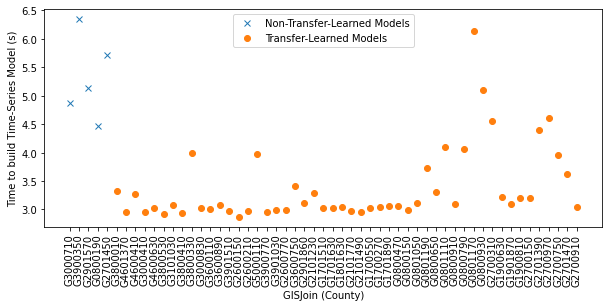

In [387]:
import matplotlib.pyplot as plt

x1 = df_centers_time['GISJoin']
y1 = df_centers_time['Time (s)']

x2 = df_children_time['GISJoin']
y2 = df_children_time['Time (s)']
plt.figure(figsize=(10, 4))

plt.xlabel('GISJoin (County)')
plt.ylabel('Time to build Time-Series Model (s)')
plt.xticks(rotation=90)

plt.plot(x1, y1, 'x')
plt.plot(x2, y2, 'o')
plt.legend(['Non-Transfer-Learned Models', 'Transfer-Learned Models'])

plt.savefig('time-series-selected-completion-time.png', dpi=500, bbox_inches = 'tight')
plt.show()

### Training `N - k` models using Trained Cluster Centers

In [239]:
def print_hyperparams(model):
    model = model.model
    print()
    print('*** Hyperparameters ***')
    print(f'daily_seasonality: {model.daily_seasonality}')
    print(f'weekly_seasonality: {model.weekly_seasonality}')
    print(f'yearly_seasonality: {model.yearly_seasonality}')
    print(f'seasonality_prior_scale: {model.seasonality_prior_scale}')
    print(f'seasonality_prior_scale: {model.seasonality_prior_scale}')
    print(f'uncertainty_samples: {model.uncertainty_samples}')
    print(f'seasonality_mode: {model.seasonality_mode}')
    print(f'interval_width: {model.interval_width}')
    print(f'growth: {model.growth}')
    print(f'n_changepoints: {model.n_changepoints}')

In [245]:
def predict_transfer(df_train, trained_model):
    m_parent = trained_model.model
    # initilaize model with hyperparameters from parent model
#     print_hyperparams(trained_model)
    m = Prophet(
        daily_seasonality = m_parent.daily_seasonality,
        weekly_seasonality = m_parent.weekly_seasonality,
        yearly_seasonality = m_parent.yearly_seasonality,
        seasonality_prior_scale = m_parent.seasonality_prior_scale,
        changepoint_prior_scale = m_parent.changepoint_prior_scale,
        uncertainty_samples = m_parent.uncertainty_samples,
        seasonality_mode = m_parent.seasonality_mode,
        interval_width = m_parent.interval_width,
        growth = m_parent.growth,
        n_changepoints = m_parent.n_changepoints,
    )
    m.fit(df_train, algorithm='LBFGS')
    df_train_future = m.make_future_dataframe(periods=365)
    df_train_forecast = m.predict(df_train_future)

    return m, df_train_future, df_train_forecast

In [246]:
trained_child_models_dict = {}
time0 = time.monotonic()

count = 1
for child in cluster_children:
    # get DF associated with child GISJOIN
    child_df = all_dfs_dict[child]
    
    # get trained parent model
    parent_model = trained_cluster_centers_dict[child_parent_dict[child]]

    time1 = time.monotonic()
    # train child model using parent model
    model, future, forecast = predict_transfer(child_df, parent_model)
    time2 = time.monotonic()
    trained_child_models_dict[child] = TrainedModel(child, model, future, forecast, time2 - time1, isParent=False)
    print(f'{count}: {trained_child_models_dict[child]}')
    count += 1
    
print(f'Time taken to build all child models: {time.monotonic() - time0}')

1: Child Model: G3800010, Time: 5.034096994204447 s
2: Child Model: G4601370, Time: 4.438506081933156 s
3: Child Model: G4600410, Time: 4.579077261965722 s
4: Child Model: G3000410, Time: 5.352720604045317 s
5: Child Model: G4600630, Time: 5.5943797749932855 s
6: Child Model: G3800530, Time: 4.540580850094557 s
7: Child Model: G3101030, Time: 5.439153308048844 s
8: Child Model: G3800410, Time: 6.523838497931138 s
9: Child Model: G3800330, Time: 8.668056658934802 s
10: Child Model: G3000830, Time: 8.389903848990798 s
11: Child Model: G3100710, Time: 4.944371040910482 s
12: Child Model: G3800250, Time: 5.313867924967781 s
13: Child Model: G3000850, Time: 7.607184648979455 s
14: Child Model: G3000050, Time: 6.67767638200894 s
15: Child Model: G3800870, Time: 6.215820774901658 s
16: Child Model: G4601050, Time: 5.506205471931025 s
17: Child Model: G3800070, Time: 4.468971318099648 s
18: Child Model: G3000550, Time: 5.729071923065931 s
19: Child Model: G4600950, Time: 5.768149734009057 s
20

KeyboardInterrupt: 

### All Models (Sequential)

In [27]:
all_results = []

count = 0
time1 = time.monotonic()
for df in all_dfs:
    count += 1
    if count % 5 == 0:
        print(count, end=', ')
    result = predict(df)
    all_results.append(result)
    
print(f'Time to train all dfs: {time.monotonic() - time1}')
print(f'#Result Dataframes: {len(all_results)}')

5, 10, 15, 20, 25, 30, 35, 40, 45, 

ValueError: Dataframe has less than 2 non-NaN rows.

In [26]:
# m.plot_components(df0_forecast)

In [25]:
# import plotly.graph_objs as go
# plot_plotly(m, df0_forecast)

# UDF Approach (with PySpark)

In [31]:
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *


result_schema = StructType([
    StructField("ds", DateType(), True),
    StructField("yhat", DoubleType(), True),
    StructField("yhat_lower", DoubleType(), True),
    StructField("yhat_upper", DoubleType(), True)
])

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def forecast_store_item(history_pd):

    # instantiate the model, configure the parameters
    model = Prophet()

    # fit the model
    model.fit(history_pd)

    # configure predictions
    future_pd = model.make_future_dataframe(
        periods=90,
        freq='d',
        include_history=True
    )

    # make predictions
    results_pd = model.predict(future_pd)

    # . . .

    # return predictions
    return results_pd

In [32]:
result_schema = StructType([
    StructField("ds", DateType(), True),
    StructField("yhat", DoubleType(), True),
    StructField("yhat_lower", DoubleType(), True),
    StructField("yhat_upper", DoubleType(), True)
])

@pandas_udf(result_schema, PandasUDFType.GROUPED_MAP)
def temp(history_pd):

    # instantiate the model, configure the parameters
    m = Prophet()
    m.fit(df0)
    df0_future = m.make_future_dataframe(periods=365)
    df0_forecast = m.predict(df0_future)

    return df0_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


In [44]:
# df0 = df0[["ds", "y"]]
# df0.set_index('ds')
# temp(df0[["ds", "GISJOIN", "y", "deaths"]])
# df0

# results = (
#     df.groupBy('GISJOIN')
#     .apply(temp)
# )
# df0_ = df0.withColumn('GISJOIN', lit(None))

# from pyspark.sql import SparkSession

# spark = SparkSession \
#     .builder\
#     .master('local')\
#     .config('spark.mongodb.input.uri', 'mongodb://localhost:27017/sustaindb.covid_county_formatted')\
#     .getOrCreate()

# spark_df = spark.read.format("mongo").option("uri",
#     "mongodb://localhost/sustaindb.covid_county_formatted").load()
# spark_df
#     .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1.jar')\

# spark.sparkContext.addPyFile('./jars/mongo-spark-connector_2.12-3.0.1.jar')
# spark.sparkContext.addPyFile('./jars/spark-core_2.12-3.0.1.jar')
# spark.sparkContext.addPyFile('./jars/spark-sql_2.12-3.0.1.jar')
# spark.sparkContext.addPyFile('./jars/spark-mllib_2.12-3.0.1.jar')
# spark.sparkContext.addPyFile('./jars/bson-4.0.5.jar')
# spark.sparkContext.addPyFile('./jars/mongo-java-driver-3.12.5.jar')

# df1 = spark.read.format('com.mongodb.spark.sql.DefaultSource')\
#             .option('database', 'sustaindb')\
#             .option('collection', 'covid_county_formatted')\
#             .load()

df = spark.read.format('json').load('./covid_county.json')

In [45]:
df = df.select('GISJOIN', 'cases', 'deaths', 'date', 'formatted_date')
df.show()

+--------+-----+------+----------+--------------------+
| GISJOIN|cases|deaths|      date|      formatted_date|
+--------+-----+------+----------+--------------------+
|G0100010|    3|     0|2020-03-25|[2020-03-25T00:00...|
|G0100010|    0|     0|2020-03-28|[2020-03-28T00:00...|
|G0100010|    0|     0|2020-03-29|[2020-03-29T00:00...|
|G0100010|    1|     0|2020-03-30|[2020-03-30T00:00...|
|G0100010|    0|     0|2020-03-31|[2020-03-31T00:00...|
|G0100010|    3|     0|2020-04-01|[2020-04-01T00:00...|
|G0100010|    0|     0|2020-04-04|[2020-04-04T00:00...|
|G0100010|    0|     0|2020-04-05|[2020-04-05T00:00...|
|G0100010|    0|     1|2020-04-06|[2020-04-06T00:00...|
|G0100010|    0|     0|2020-04-02|[2020-04-02T00:00...|
|G0100010|    0|     0|2020-04-07|[2020-04-07T00:00...|
|G0100010|    0|     0|2020-04-08|[2020-04-08T00:00...|
|G0100010|    5|     0|2020-04-09|[2020-04-09T00:00...|
|G0100010|    0|     0|2020-04-10|[2020-04-10T00:00...|
|G0100010|    2|     0|2020-04-11|[2020-04-11T00

In [46]:
# df0 = df0.rename(columns = {
#     'date': 'ds',
#     'cases': 'y'
# })
df_cases = df.select('GISJOIN', 'date', 'cases').withColumnRenamed('date', 'ds').withColumnRenamed('cases', 'y')
# df_cases.show()

results = (
    df_cases.groupBy('GISJOIN')
    .apply(temp)
)
results.toPandas()

Py4JJavaError: An error occurred while calling o530.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 25.0 failed 1 times, most recent failure: Lost task 0.0 in stage 25.0 (TID 44, 10.253.202.195, executor driver): java.lang.UnsupportedOperationException: sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
	at io.netty.util.internal.PlatformDependent.directBuffer(PlatformDependent.java:490)
	at io.netty.buffer.NettyArrowBuf.getDirectBuffer(NettyArrowBuf.java:243)
	at io.netty.buffer.NettyArrowBuf.nioBuffer(NettyArrowBuf.java:233)
	at io.netty.buffer.ArrowBuf.nioBuffer(ArrowBuf.java:245)
	at org.apache.arrow.vector.ipc.message.ArrowRecordBatch.computeBodyLength(ArrowRecordBatch.java:222)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.serialize(MessageSerializer.java:240)
	at org.apache.arrow.vector.ipc.ArrowWriter.writeRecordBatch(ArrowWriter.java:132)
	at org.apache.arrow.vector.ipc.ArrowWriter.writeBatch(ArrowWriter.java:120)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.$anonfun$writeIteratorToStream$1(ArrowPythonRunner.scala:94)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.writeIteratorToStream(ArrowPythonRunner.scala:101)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:383)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1932)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:218)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2120)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2139)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2164)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:385)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3450)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3618)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:100)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:160)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:87)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:764)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3616)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3447)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.UnsupportedOperationException: sun.misc.Unsafe or java.nio.DirectByteBuffer.<init>(long, int) not available
	at io.netty.util.internal.PlatformDependent.directBuffer(PlatformDependent.java:490)
	at io.netty.buffer.NettyArrowBuf.getDirectBuffer(NettyArrowBuf.java:243)
	at io.netty.buffer.NettyArrowBuf.nioBuffer(NettyArrowBuf.java:233)
	at io.netty.buffer.ArrowBuf.nioBuffer(ArrowBuf.java:245)
	at org.apache.arrow.vector.ipc.message.ArrowRecordBatch.computeBodyLength(ArrowRecordBatch.java:222)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.serialize(MessageSerializer.java:240)
	at org.apache.arrow.vector.ipc.ArrowWriter.writeRecordBatch(ArrowWriter.java:132)
	at org.apache.arrow.vector.ipc.ArrowWriter.writeBatch(ArrowWriter.java:120)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.$anonfun$writeIteratorToStream$1(ArrowPythonRunner.scala:94)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.writeIteratorToStream(ArrowPythonRunner.scala:101)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:383)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1932)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:218)


In [3]:
 from pyspark.sql import SparkSession 

 spark = SparkSession.builder.master("spark://lattice-100:8079").getOrCreate() 
 print(spark.sparkContext.version)

3.0.1
